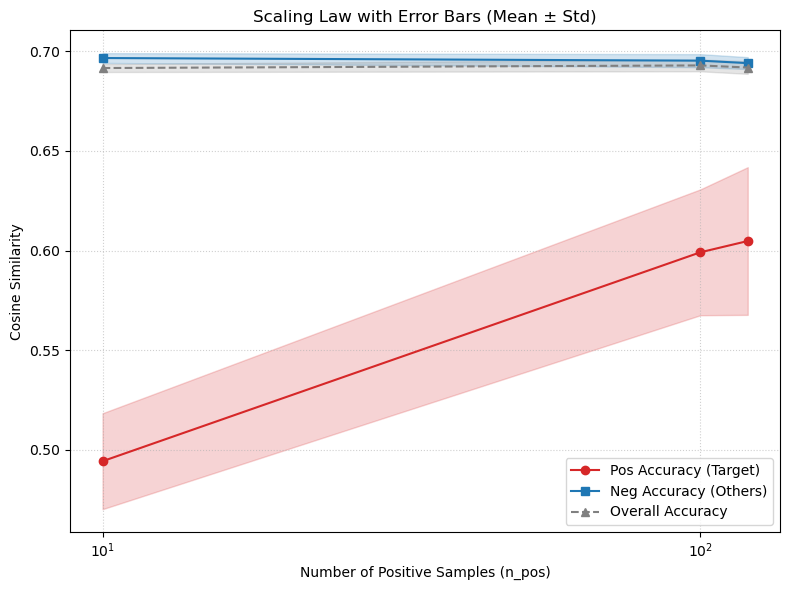

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

FLAG_COLUMN = "has_F"
TRAIN_MODE = "vanilla"  # "vanilla" or "class_balanced_loss"
VAL_METRIC = "val_loss"  # {"val_loss", "val_pos_loss"}

# 1. データの読み込み
df = pd.read_csv(f"output/csv/{FLAG_COLUMN}-{TRAIN_MODE}-esmetric={VAL_METRIC}-ae-v2.csv") 
# ※ここでは提示されたデータ形式と同じ構造を持つDataFrameがあると仮定します

# 2. 集計 (seedごとの平均と標準偏差を算出)
grouped = df.groupby("n_pos_req").agg({
    "pos_acc": ["mean", "std"],
    "neg_acc": ["mean", "std"],
    "overall_acc": ["mean", "std"]
}).reset_index()

# カラム名の整理 (pos_acc_mean, pos_acc_std ... という名前にする)
grouped.columns = ['_'.join(col).strip() if col[1] else col[0] for col in grouped.columns.values]

# 3. プロット
plt.figure(figsize=(8, 6))

x = grouped["n_pos_req"]

# --- Pos Accuracy (赤色) ---
mean = grouped["pos_acc_mean"]
std = grouped["pos_acc_std"]
plt.plot(x, mean, marker='o', color='tab:red', label='Pos Accuracy (Target)')
# ★ここで fill_between を使用
plt.fill_between(x, mean - std, mean + std, color='tab:red', alpha=0.2)

# --- Neg Accuracy (青色) ---
mean = grouped["neg_acc_mean"]
std = grouped["neg_acc_std"]
plt.plot(x, mean, marker='s', color='tab:blue', label='Neg Accuracy (Others)')
plt.fill_between(x, mean - std, mean + std, color='tab:blue', alpha=0.2)

# --- Overall Accuracy (灰色) ---
mean = grouped["overall_acc_mean"]
std = grouped["overall_acc_std"]
plt.plot(x, mean, marker='^', linestyle='--', color='gray', label='Overall Accuracy')
plt.fill_between(x, mean - std, mean + std, color='gray', alpha=0.2)

# 装飾
plt.xlabel('Number of Positive Samples (n_pos)')
plt.ylabel('Cosine Similarity')
plt.title('Scaling Law with Error Bars (Mean ± Std)')
plt.grid(True, linestyle=':', alpha=0.6)
plt.xscale('symlog', linthresh=1)
# plt.ylim(0.41, 0.77)
plt.legend()

plt.tight_layout()
# plt.savefig(f"tmp/{FLAG_COLUMN}-{TRAIN_MODE}-esmetric={VAL_METRIC}-ae.png", dpi=300)
plt.show()

   n_train  n_val  n_test  seed   pos_acc   neg_acc  overall_acc  best_epoch
0      500    500    1000     0  0.500628  0.547574     0.546166          68
1      500    500    1000     1  0.410264  0.550959     0.548286          83
2      500    500    1000     2  0.485250  0.545782     0.543966          70
3      500    500    1000     3  0.386713  0.562377     0.558688          96
4      500    500    1000     4  0.460733  0.556387     0.554187          69
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   n_train      25 non-null     int64  
 1   n_val        25 non-null     int64  
 2   n_test       25 non-null     int64  
 3   seed         25 non-null     int64  
 4   pos_acc      25 non-null     float64
 5   neg_acc      25 non-null     float64
 6   overall_acc  25 non-null     float64
 7   best_epoch   25 non-null     int64  
dtypes: float64(

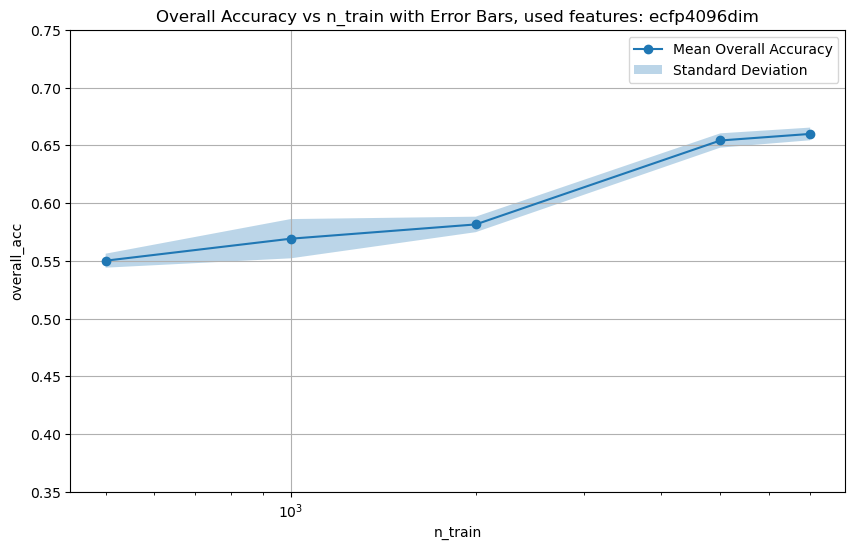

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

suffix = 'ecfp4096dim'  # 'ae' or 'bert'

# Load the dataframe.
df_has_F_vanilla_scaling = pd.read_csv(f'tmp/scaling/scaling-has_F-{suffix}.csv')

# Print some info.
print(df_has_F_vanilla_scaling.head())
print(df_has_F_vanilla_scaling.info())

# Group by n_train and calculate mean and std for overall_acc
grouped = df_has_F_vanilla_scaling.groupby('n_train')['overall_acc'].agg(['mean', 'std']).reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(grouped['n_train'], grouped['mean'], label='Mean Overall Accuracy', marker='o')
plt.fill_between(grouped['n_train'], 
                 grouped['mean'] - grouped['std'], 
                 grouped['mean'] + grouped['std'], 
                 alpha=0.3, label='Standard Deviation')

plt.xlabel('n_train')
plt.ylabel('overall_acc')
plt.xscale('log')
plt.ylim(0.35, 0.75)
plt.title('Overall Accuracy vs n_train with Error Bars, used features: ' + suffix)
plt.legend()
plt.grid(True)

# Save the plot
# plt.savefig(f'tmp/png/overall_scaling-{suffix}.png')

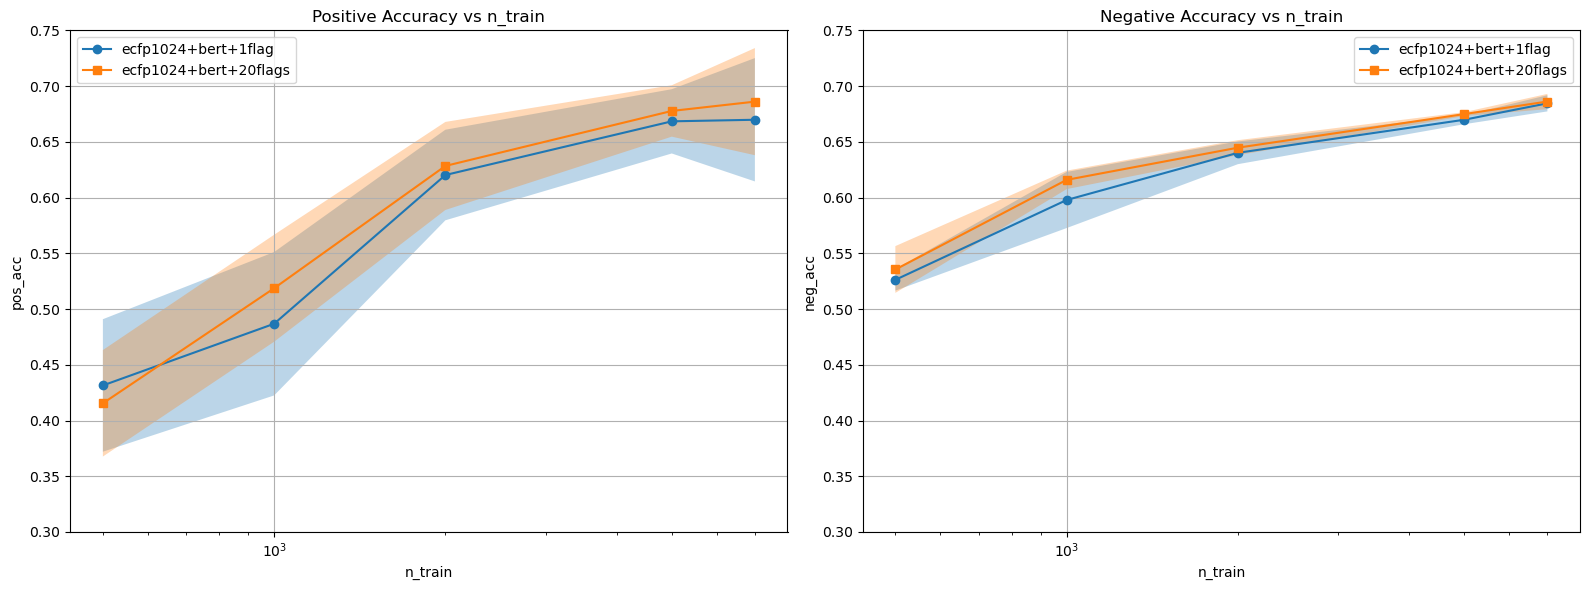

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

first_feature = 'ecfp1024+bert+1flag'
second_feature = 'ecfp1024+bert+20flags'

# Load the dataframes
df_ecfp = pd.read_csv(f'tmp/scaling/scaling-has_F-{first_feature}.csv')
df_multi = pd.read_csv(f'tmp/scaling/scaling-has_F-{second_feature}.csv')

# Aggregation function
def aggregate_data(df, metric):
    return df.groupby('n_train')[metric].agg(['mean', 'std']).reset_index()

# Prepare data for pos_acc
first_pos = aggregate_data(df_ecfp, 'pos_acc')
second_pos = aggregate_data(df_multi, 'pos_acc')

# Prepare data for neg_acc
first_neg = aggregate_data(df_ecfp, 'neg_acc')
second_neg = aggregate_data(df_multi, 'neg_acc')
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot pos_acc
ax = axes[0]
ax.plot(first_pos['n_train'], first_pos['mean'], label=first_feature, marker='o')
ax.fill_between(first_pos['n_train'], 
                first_pos['mean'] - first_pos['std'], 
                first_pos['mean'] + first_pos['std'], 
                alpha=0.3)

ax.plot(second_pos['n_train'], second_pos['mean'], label=second_feature, marker='s')
ax.fill_between(second_pos['n_train'], 
                second_pos['mean'] - second_pos['std'], 
                second_pos['mean'] + second_pos['std'], 
                alpha=0.3)

ax.set_xlabel('n_train')
ax.set_ylabel('pos_acc')
ax.set_title('Positive Accuracy vs n_train')
ax.legend()
ax.grid(True)
ax.set_ylim(0.30, 0.75)
ax.set_xscale('log')

# Plot neg_acc
ax = axes[1]
ax.plot(first_neg['n_train'], first_neg['mean'], label=first_feature, marker='o')
ax.fill_between(first_neg['n_train'], 
                first_neg['mean'] - first_neg['std'], 
                first_neg['mean'] + first_neg['std'], 
                alpha=0.3)

ax.plot(second_neg['n_train'], second_neg['mean'], label=second_feature, marker='s')
ax.fill_between(second_neg['n_train'], 
                second_neg['mean'] - second_neg['std'], 
                second_neg['mean'] + second_neg['std'], 
                alpha=0.3)

ax.set_xlabel('n_train')
ax.set_ylabel('neg_acc')
ax.set_title('Negative Accuracy vs n_train')
ax.legend()
ax.grid(True)
ax.set_ylim(0.30, 0.75)
ax.set_xscale('log')

plt.tight_layout()
plt.savefig(f'tmp/png/comparison_scaling_{first_feature}_vs_{second_feature}.png', dpi=300)


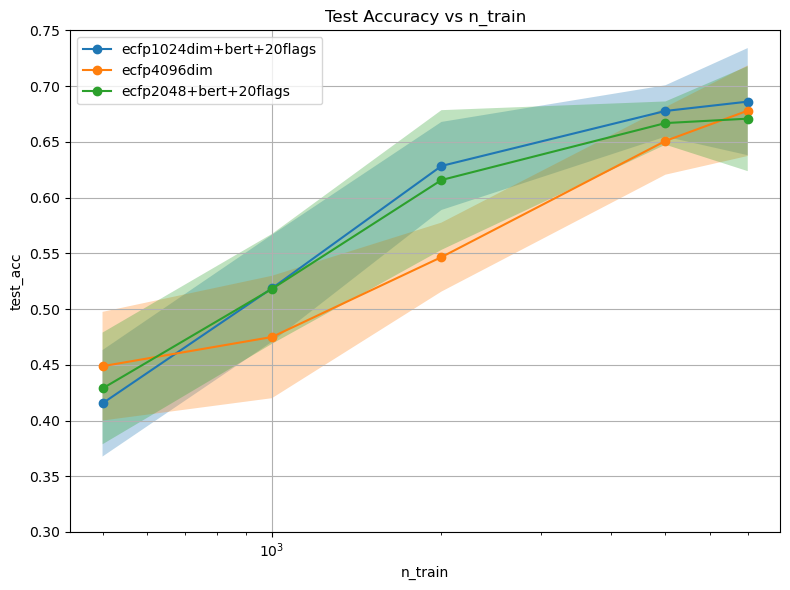

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

suf0 = 'ecfp1024dim+bert+20flags' # baseline1
suf1 = 'ecfp4096dim'   # baseline2
suf2 = 'ecfp2048+bert+20flags'
# suf3 = 'ecfp2048+bert+20flags'


sufs = [suf0, suf1, suf2]

df_0 = None
df_2 = None
df_0 = pd.read_csv(f'tmp/scaling/scaling-has_F-{suf0}.csv')
df_1 = pd.read_csv(f'tmp/scaling/scaling-has_F-{suf1}.csv')
df_2 = pd.read_csv(f'tmp/scaling/scaling-has_F-{suf2}.csv')
# df_3 = pd.read_csv(f'tmp/scaling/scaling-has_F-{suf3}.csv')


# Aggregation function
def aggregate_data(df, metric):
    return df.groupby('n_train')[metric].agg(['mean', 'std']).reset_index()

# Plotting
plt.figure(figsize=(8, 6))

for df, suf in zip([df_0, df_1, df_2], [suf0, suf1, suf2]):
    df_pos = aggregate_data(df, 'pos_acc')
    df_neg = aggregate_data(df, 'neg_acc')

    # Plot pos_acc
    plt.plot(df_pos['n_train'], df_pos['mean'], label=suf, marker='o')
    plt.fill_between(df_pos['n_train'], 
                    df_pos['mean'] - df_pos['std'], 
                    df_pos['mean'] + df_pos['std'], 
                    alpha=0.3)


plt.xlabel('n_train')
plt.ylabel('test_acc')
plt.title('Test Accuracy vs n_train')
plt.legend()
plt.grid(True)
plt.ylim(0.30, 0.75)
plt.xscale('log')

plt.tight_layout()
# plt.savefig(f'tmp/png/comparison_scaling_v0.1.png', dpi=300)


ecfp1024dim+bert+20flags = baseline1
ecfp4096dim = baseline2

入力を変えた実験のメモ
- ecfp1024+rdkit2d
    - n=500, 1000での精度はbaseline1, 2より上
    - それ以上ではecfp4096と同様
- ecfp1024+rdkit3d
    - n=5000でbaseline1と同等
    - それ以下ではecfo4096と同等かそれ以下
- ecfp1024+rdkit2d+rdkit3d
    - ガッタガタ(comparison_scaling_v0.1)

特徴量 'ecfp+rdkit2d+flag+bert' のデータがまだありません。


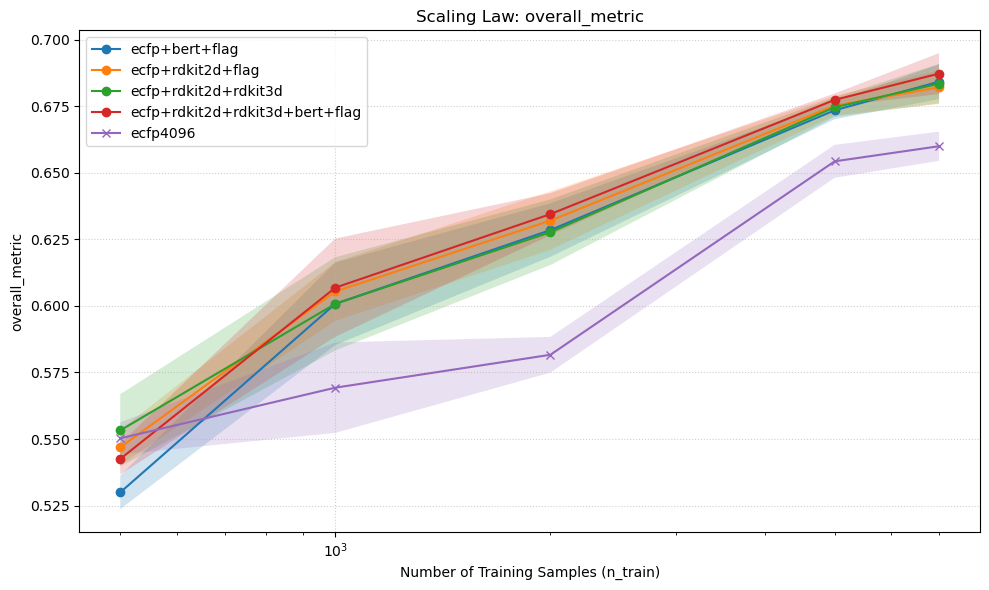

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools

# --- 設定 ---
CSV_PATH = "tmp/scaling/scaling_experiment_results_ALL.csv" # 出力ファイル名に合わせて変更
METRIC_COL = "overall_metric"  # "pos_metric", "val_loss" など見たい指標
LOWER_IS_BETTER = False         # LossならTrue, Accuracy/CosSimならFalse

def plot_scaling_law():
    # 1. データ読み込み
    try:
        df = pd.DataFrame(pd.read_csv(CSV_PATH))
    except FileNotFoundError:
        print("まだCSVがありません。計算が終わるまでコーヒーでも飲んで待ちましょう☕")
        return

    # 2. 注目したい組み合わせをフィルタリング (全31種は多すぎるため)
    # ここに比較したい特徴量の文字列を指定します
    # target_features = [
    #     'rdkit3d+rdkit3d',
    #     'rdkit2d+bert',
    #     'rdkit2d+flag'
    # ]
    # ALL_FEATURES = ["ecfp", "rdkit2d", "rdkit3d", "bert", "flag"]
    # target_features = []
    # for f1, f2, f3, f4, f5 in itertools.combinations(ALL_FEATURES, 5):
    #     target_features.append(f"{f1}+{f2}+{f3}+{f4}+{f5}")

    target_features = [
        "ecfp+bert+flag",        # Level 1 Baseline
        "ecfp+rdkit2d+flag",             # Level 2 Baseline
        "ecfp+rdkit2d+rdkit3d",     # +3D
        "ecfp+rdkit2d+flag+bert",        # +BERT
        "ecfp+rdkit2d+rdkit3d+bert+flag" # All
    ]
    target_features.append('ecfp4096')  # ECFP4096も比較
    plt.figure(figsize=(10, 6))
    
    for feature in target_features:
        # データフレームをフィルタリング
        plot_df = df[df["feature_type"] == feature].copy()
        if len(plot_df) == 0:
            print(f"特徴量 '{feature}' のデータがまだありません。")
            continue

        # 3. 集計 (seedごとの平均と標準偏差を算出)
        grouped = plot_df.groupby("n_train").agg({
            METRIC_COL: ["mean", "std"]
        }).reset_index()
        grouped.columns = ['n_train', 'mean', 'std']

        if feature == 'ecfp4096':
            marker_style = 'x'
        else:
            marker_style = 'o'

        # 4. プロット作成
        plt.plot(grouped["n_train"], grouped["mean"], marker=marker_style, label=feature)
        plt.fill_between(grouped["n_train"], 
                         grouped["mean"] - grouped["std"], 
                         grouped["mean"] + grouped["std"], 
                         alpha=0.2)
    # 装飾
    plt.xlabel('Number of Training Samples (n_train)')
    plt.ylabel(METRIC_COL)
    plt.title('Scaling Law: ' + METRIC_COL)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.xscale('log')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'tmp/comparison_overall.png', dpi=300)
    plt.show()
    

if __name__ == "__main__":
    plot_scaling_law()

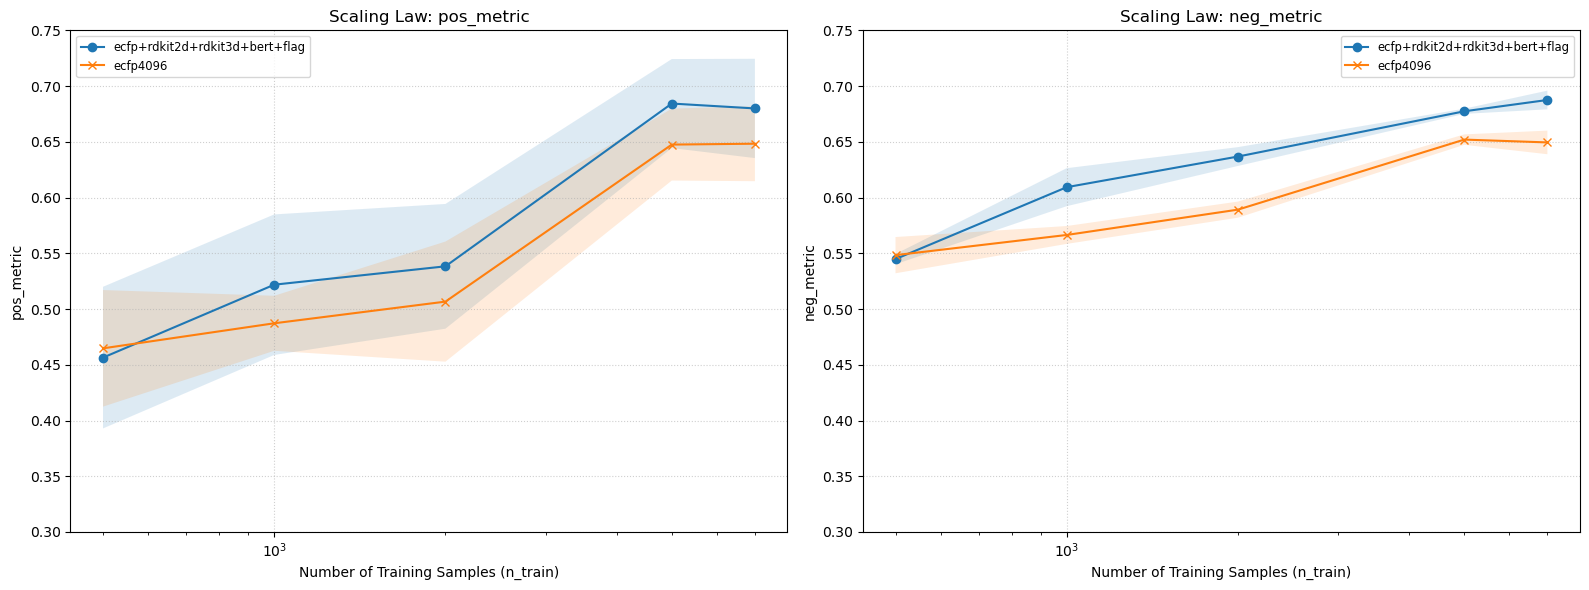

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools

# --- 設定 ---
CSV_PATH = "tmp/scaling/scaling_experiment_results_ALL.csv"
# 表示したい2つの指標
METRICS = {
    "pos": "pos_metric",  # 左側のグラフ
    "neg": "neg_metric"   # 右側のグラフ
}

def plot_scaling_law_side_by_side():
    # 1. データ読み込み
    try:
        df = pd.DataFrame(pd.read_csv(CSV_PATH))
    except FileNotFoundError:
        print("CSVファイルが見つかりません。パスを確認してください。")
        return

    # 2. 注目したい組み合わせを作成 
    ALL_FEATURES = ["ecfp", "rdkit2d", "rdkit3d", "bert", "flag"]
    target_features = []
    
    # 2つの組み合わせを生成してリスト化
    for f1, f2, f3, f4, f5 in itertools.combinations(ALL_FEATURES, 5):
        target_features.append(f"{f1}+{f2}+{f3}+{f4}+{f5}")
    
    target_features.append('ecfp4096')

    # 3. キャンバスの準備 (1行2列)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 左: pos_metric, 右: neg_metric でループ
    for i, (key, metric_col) in enumerate(METRICS.items()):
        ax = axes[i] # 現在の描画対象のグラフ
        
        for feature in target_features:
            # データフレームをフィルタリング
            plot_df = df[df["feature_type"] == feature].copy()
            if len(plot_df) == 0:
                continue

            # 集計 (n_trainごとの平均と標準偏差)
            grouped = plot_df.groupby("n_train").agg({
                metric_col: ["mean", "std"]
            }).reset_index()
            
            # MultiIndexカラムをフラットにする
            grouped.columns = ['n_train', 'mean', 'std']

            # プロット作成 (散布図 + 折れ線)
            # 散布図として点を見たい場合は linestyle='None' にしてください
            if feature == 'ecfp4096':
                marker_style = 'x'  # 特別なマーカー
            else:
                marker_style = 'o'
            ax.plot(grouped["n_train"], grouped["mean"], marker=marker_style, label=feature)
            
            # エラーバー（標準偏差）の帯
            ax.fill_between(grouped["n_train"], 
                            grouped["mean"] - grouped["std"], 
                            grouped["mean"] + grouped["std"], 
                            alpha=0.15)

        # グラフごとの装飾
        ax.set_xlabel('Number of Training Samples (n_train)')
        ax.set_ylabel(metric_col)
        ax.set_title(f'Scaling Law: {metric_col}')
        ax.grid(True, linestyle=':', alpha=0.6)
        ax.set_xscale('log')
        
        # 凡例はグラフ内が混雑しないよう、右側のグラフにだけつけるなどの工夫も可能です
        # 今回は両方につけています
        ax.legend(fontsize='small')
        ax.set_ylim(0.30, 0.75)

    plt.tight_layout()
    plt.savefig(f'tmp/png/comparison_quintuples_pos_neg.png', dpi=300)
    plt.show()

if __name__ == "__main__":
    plot_scaling_law_side_by_side()